# LightGBM

In [1]:
# Built-in packages
import string
import os
import time as t
import warnings
import sys

# To ignore all warnings that arise here to enhance clarity
warnings.filterwarnings('ignore')

# Basic Packages for Data Wrangling
import spacy
import pymysql
import pandas as pd
import numpy as np
from numpy import array
import datetime as dt
import pycountry as pc # Country Name Converter

import matplotlib.pyplot as plt # For data visualisation
import seaborn as sns # For data visualisation
import re # For regular expression
from tqdm import tqdm # Processing bar
from zhon import hanzi # For handling the chinsese punctuation
from scipy.optimize import linear_sum_assignment # For hungarian algorithm

# For lightGBM
import lightgbm as lgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import load_breast_cancer,load_boston,load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score, precision_recall_fscore_support
from sklearn.metrics import multilabel_confusion_matrix

In [2]:
df_gbm = pd.read_csv('../Data/df_gbm.csv')
df_nih = df_gbm[(df_gbm.agency == 'NIH')]
df_other = df_gbm[(df_gbm.agency != 'NIH')]
df_nih.reset_index(drop = True, inplace = True)
df_other.reset_index(drop = True, inplace = True)

In [3]:
sc=StandardScaler()
sc.fit(df_nih[['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']])
sc.fit(df_other[['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']])
df_nih_sdd=pd.DataFrame(sc.fit_transform(df_nih[['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']]))
df_other_sdd=pd.DataFrame(sc.fit_transform(df_other[['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']]))
df_nih_sdd.columns = ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']
df_other_sdd.columns = ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']
df_nih_sdd['amount'] = df_nih['amount']
df_other_sdd['amount'] = df_other['amount']
df_nih_sdd['target'] = df_nih['target']
df_other_sdd['target'] = df_other['target']

In [4]:
def lightgbm_quick_prediction(features, target, learning_rate = 0.1, max_depth = 80, num_leaves = 200, num_interations = 100, bagging_freq = 1, pos_bagging_fraction = 1, neg_bagging_fraction = 1):
    """ quickly creating lightgbm and get mode accuracy """
    #train-test-split
    X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.3)
    #Converting the dataset in proper LGB format
    d_train=lgb.Dataset(X_train, label=y_train)
    
    #setting up the parameters
    params={}
    params['learning_rate']= learning_rate
    params['boosting_type']= 'gbdt' #GradientBoostingDecisionTree
    params['objective']= 'multiclass' #Multi-class target feature
    params['metric']= 'multi_logloss' #metric for multi-class
    params['max_depth'] = max_depth
    params['num_leaves'] = num_leaves #理论上 num_leaves < 2 ^ (max_depth)，否则容易导致 overfitting
    params['num_class'] = 3 #no.of unique values in the target class not inclusive of the end value
    params['num_iterations'] = num_interations
    params['bagging_freq'] = bagging_freq
    params['pos_bagging_fraction'] = pos_bagging_fraction
    params['neg_bagging_fraction'] = neg_bagging_fraction
    
    #training the model
    clf=lgb.train(params,d_train, 200)  #training the model on 100 epocs
    
    #prediction on the test dataset
    y_pred_1=clf.predict(X_test)
    #printing the predictions
    #argmax() method
    y_pred_2 = [np.argmax(line) for line in y_pred_1]
    
    #roc_auc_score metric
    prec_score = precision_score(y_pred_2, y_test, average=None).mean()
    print("Final Accuracy:" + str(prec_score))
    confusion_matrices = multilabel_confusion_matrix(y_test, y_pred_2)
    return y_test, y_pred_1, y_pred_2, prec_score, confusion_matrices

## Preditions of Total funding amount

In [5]:
## Model_all_topics
actual1, prob1, pred1, accuracy1, confusion_matrices1 = lightgbm_quick_prediction(df_nih_sdd.iloc[:,8:9], 
                                                                               df_nih_sdd.target, 
                                                                               learning_rate=0.02, 
                                                                               max_depth=80, 
                                                                               num_leaves=200, 
                                                                               num_interations=150)

## Model_selected_topics
actual2, prob2, pred2, accuracy2, confusion_matrices2 = lightgbm_quick_prediction(df_nih_sdd.iloc[:,0:9], 
                                                                                       df_nih_sdd.target, 
                                                                                       learning_rate=0.02, 
                                                                                       max_depth=80, 
                                                                                       num_leaves=200, 
                                                                                       num_interations=150)

## Model_selected_topics
actual3, prob3, pred3, accuracy3, confusion_matrices3 = lightgbm_quick_prediction(df_nih_sdd.iloc[:,0:8], 
                                                                                       df_nih_sdd.target, 
                                                                                       learning_rate=0.02, 
                                                                                       max_depth=80, 
                                                                                       num_leaves=200, 
                                                                                       num_interations=150)

## Model_all_topics
actual4, prob4, pred4, accuracy4, confusion_matrices4 = lightgbm_quick_prediction(df_other_sdd.iloc[:,8:9], 
                                                                                   df_other_sdd.target, 
                                                                                   learning_rate=0.02, 
                                                                                   max_depth=80, 
                                                                                   num_leaves=200,
                                                                                  num_interations=150) 
## Model_selected_topics
actual5, prob5, pred5, accuracy5, confusion_matrices5 = lightgbm_quick_prediction(df_other_sdd.iloc[:,0:9], 
                                                                                       df_other_sdd.target, 
                                                                                       learning_rate=0.02, 
                                                                                       max_depth=80, 
                                                                                       num_leaves=200, 
                                                                                       num_interations=150)
                        
    
actual6, prob6, pred6, accuracy6, confusion_matrices6 = lightgbm_quick_prediction(df_other_sdd.iloc[:,0:8], 
                                                                                  df_other_sdd.target, 
                                                                                  learning_rate=0.02, 
                                                                                  max_depth=80, 
                                                                                  num_leaves=200, 
                                                                                  num_interations=150)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 49589, number of used features: 1
[LightGBM] [Info] Start training from score -1.196920
[LightGBM] [Info] Start training from score -0.962018
[LightGBM] [Info] Start training from score -1.152787
Final Accuracy:0.5196284428208122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 49589, number of used features: 9
[LightGBM] [Info] Start training from score -1.202274
[LightGBM] [Info] Start training from score -0.957174
[LightGBM] [Info] Start training from score -1.153554
Final Accuracy:0.6281990636408323
[LightGBM] [Warning] Auto-c

## Preditions of daily funding amount

In [6]:
df_nih_daily = pd.read_csv('../Data/df_nih.csv')
df_other_daily = pd.read_csv('../Data/df_other.csv')

In [7]:
sc=StandardScaler()
sc.fit(df_nih_daily[['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']])
sc.fit(df_other_daily[['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']])
df_nih_daily_sdd=pd.DataFrame(sc.fit_transform(df_nih_daily[['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']]))
df_other_daily_sdd=pd.DataFrame(sc.fit_transform(df_other_daily[['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']]))
df_nih_daily_sdd.columns = ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']
df_other_daily_sdd.columns = ['t0', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 'project_duration']
df_nih_daily_sdd['daily_amount'] = df_nih_daily['daily_amount']
df_other_daily_sdd['daily_amount'] = df_other_daily['daily_amount']
df_nih_daily_sdd['target'] = df_nih_daily['target']
df_other_daily_sdd['target'] = df_other_daily['target']

In [8]:
## Model_all_topics
actual7, prob7, pred7, accuracy7, confusion_matrices7 = lightgbm_quick_prediction(df_nih_daily_sdd.iloc[:,8:9], 
                                                                               df_nih_daily_sdd.target, 
                                                                               learning_rate=0.02, 
                                                                               max_depth=80, 
                                                                               num_leaves=200, 
                                                                               num_interations=150)

## Model_selected_topics
actual8, prob8, pred8, accuracy8, confusion_matrices8 = lightgbm_quick_prediction(df_nih_daily_sdd.iloc[:,0:9], 
                                                                                       df_nih_daily_sdd.target, 
                                                                                       learning_rate=0.02, 
                                                                                       max_depth=80, 
                                                                                       num_leaves=200, 
                                                                                       num_interations=150)

## Model_selected_topics
actual9, prob9, pred9, accuracy9, confusion_matrices9 = lightgbm_quick_prediction(df_nih_daily_sdd.iloc[:,0:8], 
                                                                                       df_nih_daily_sdd.target, 
                                                                                       learning_rate=0.02, 
                                                                                       max_depth=80, 
                                                                                       num_leaves=200, 
                                                                                       num_interations=150)

## Model_all_topics
actual10, prob10, pred10, accuracy10, confusion_matrices10 = lightgbm_quick_prediction(df_other_daily_sdd.iloc[:,8:9], 
                                                                               df_other_daily_sdd.target, 
                                                                               learning_rate=0.02, 
                                                                               max_depth=80, 
                                                                               num_leaves=200, 
                                                                               num_interations=150)

## Model_selected_topics
actual11, prob11, pred11, accuracy11, confusion_matrices11 = lightgbm_quick_prediction(df_other_daily_sdd.iloc[:,0:9], 
                                                                                       df_other_daily_sdd.target, 
                                                                                       learning_rate=0.02, 
                                                                                       max_depth=80, 
                                                                                       num_leaves=200, 
                                                                                       num_interations=150)

## Model_selected_topics
actual12, prob12, pred12, accuracy12, confusion_matrices12 = lightgbm_quick_prediction(df_other_daily_sdd.iloc[:,0:8], 
                                                                                       df_other_daily_sdd.target, 
                                                                                       learning_rate=0.02, 
                                                                                       max_depth=80, 
                                                                                       num_leaves=200, 
                                                                                       num_interations=150)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 49589, number of used features: 1
[LightGBM] [Info] Start training from score -1.101925
[LightGBM] [Info] Start training from score -1.094366
[LightGBM] [Info] Start training from score -1.099561
Final Accuracy:0.5198504971774466
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 49589, number of used features: 9
[LightGBM] [Info] Start training from score -1.100894
[LightGBM] [Info] Start training from score -1.097383
[LightGBM] [Info] Start training from score -1.0975

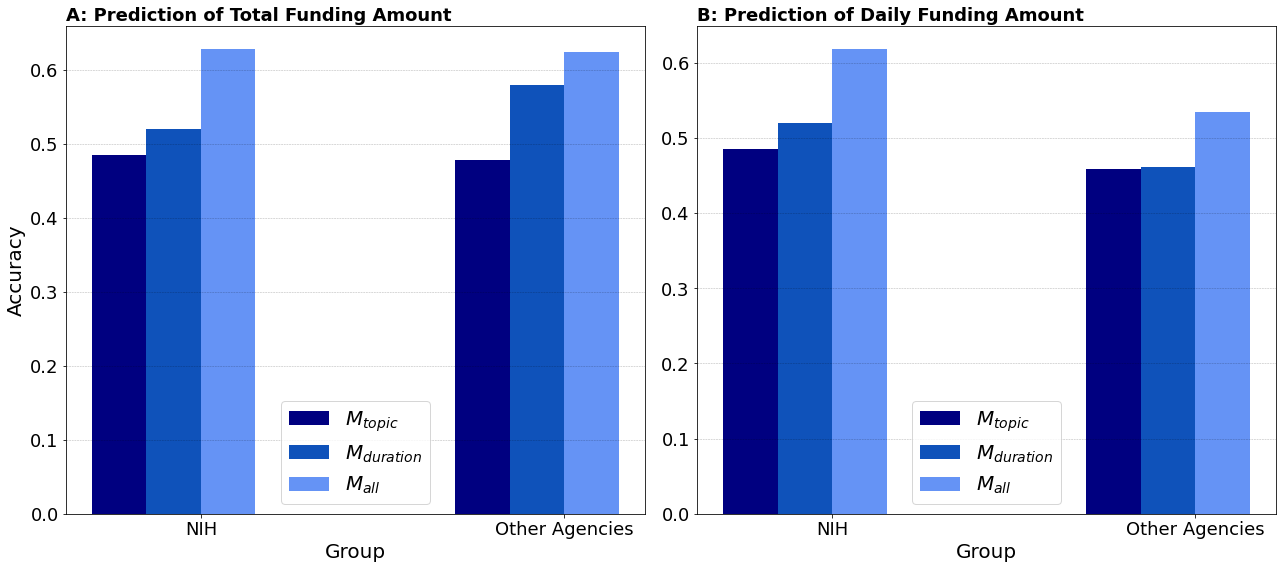

In [9]:
data = np.array([[accuracy3, accuracy1, accuracy2], [accuracy6, accuracy4, accuracy5]])
data2 = np.array([[accuracy9, accuracy7, accuracy8], [accuracy12, accuracy10, accuracy11]])
length = len(data)

# Set plot parameters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 8))
width = 0.15 # width of bar
x = np.arange(length)

ax1.bar(x, data[:,0], width, color='#000080', label=r'$M_{topic}$')
ax1.bar(x + width, data[:,1], width, color='#0F52BA', label=r'$M_{duration}$')
ax1.bar(x + (2 * width), data[:,2], width, color='#6593F5', label=r'$M_{all}$')

ax1.set_ylabel('Accuracy', fontsize = 20)
ax1.set_xticks(x + width + width/2)
ax1.tick_params(axis='both', labelsize=18)
ax1.set_xticklabels(["NIH", "Other Agencies"], fontsize = 18)
# ax1.set_xticks([])
ax1.set_xlabel('Group', fontsize = 20)
ax1.legend(fontsize = 20)

ax2.bar(x, data2[:,0], width, color='#000080', label=r'$M_{topic}$')
ax2.bar(x + width, data2[:,1], width, color='#0F52BA', label=r'$M_{duration}$')
ax2.bar(x + (2 * width), data2[:,2], width, color='#6593F5', label=r'$M_{all}$')

ax2.set_ylabel('', fontsize = 20)
ax2.set_xticks(x + width + width/2)
ax2.tick_params(axis='both', labelsize=18)
ax2.set_xticklabels(["NIH", "Other Agencies"], fontsize = 18)
ax2.set_xlabel('Group', fontsize = 20)
# ax2.set_yticks([])
ax2.legend(fontsize = 20)

def get_axis_limits(ax, scale=.9):
    return (ax.get_xlim()[0]*scale, ax.get_ylim()[1]*scale)

ax1.text(get_axis_limits(ax1, scale=1)[0], get_axis_limits(ax1, scale=1.01)[1], 'A: Prediction of Total Funding Amount', fontsize = 18, weight = 'bold')
ax2.text(get_axis_limits(ax2, scale=1)[0], get_axis_limits(ax2, scale=1.01)[1], 'B: Prediction of Daily Funding Amount', fontsize = 18, weight = 'bold')

ax1.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
ax2.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

plt.tight_layout()
# plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.savefig('../project_latex/img/accuracy_daily2.pdf', dpi = 600)